# 04. NFL Win Prediction Model (Pre-Game Rolling EPA + Static & Dynamic Styles)

**Goal:**  
Build a pre-game win probability model using rolling EPA features, static team style clusters, dynamic per-game clusters, and previous-season priors.

**Contents:**  
- Merge rolling EPA (from Notebook 03)  
- Merge static team-season clusters (from Notebook 02)  
- Merge dynamic per-game clusters  
- Create pre-game feature differences (offense/defense/rest_days/win_pct)  
- Train–test split: Train 2019–2023, Test 2024  
- Models: Logistic Regression, RandomForest, GradientBoosting, XGBoost, MLP  
- Evaluate using Accuracy, Brier Score, ROC-AUC  
- SHAP analysis for interpretability  

**Output File Saved:**  
- `data/processed/matchups_pre_game_2019_2024_with_clusters.csv`

This dataset is used by Notebook 05 for full-season simulation.

## 1. Setup & Paths

In [2]:
# Cell 1 — Setup & paths (fixed project root)

import sys
from pathlib import Path

import numpy as np
import pandas as pd
import nfl_data_py as nfl

import matplotlib.pyplot as plt
import seaborn as sns

print("Python:", sys.executable)
print("pandas:", pd.__version__)

# Detect notebook directory
NB_DIR = Path.cwd()
print("Notebook directory:", NB_DIR)

# If notebook is inside .../nfl-epa-analysis/notebooks/model,
# then the project root is two levels up.
PROJECT_ROOT = NB_DIR.parents[1]  # go up from model -> notebooks -> project root

DATA_DIR = PROJECT_ROOT / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("RAW_DIR:", RAW_DIR)
print("PROCESSED_DIR:", PROCESSED_DIR)

RAW_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

Python: /opt/homebrew/anaconda3/envs/ds_study/bin/python
pandas: 2.3.3
Notebook directory: /Users/minseobeom/Desktop/nfl-epa-analysis/notebooks/model
PROJECT_ROOT: /Users/minseobeom/Desktop/nfl-epa-analysis
RAW_DIR: /Users/minseobeom/Desktop/nfl-epa-analysis/data/raw
PROCESSED_DIR: /Users/minseobeom/Desktop/nfl-epa-analysis/data/processed


## 2. Load PBP Data (2019–2024)

In [3]:
# Cell 2 — Load play-by-play data (2019–2024) with caching

SEASONS = list(range(2019, 2025))  # 2019~2024
PBP_FILE = RAW_DIR / "pbp_2019_2024.parquet"

if PBP_FILE.exists():
    print(f"[INFO] Loading cached PBP file: {PBP_FILE}")
    pbp_df = pd.read_parquet(PBP_FILE)
else:
    print("[INFO] Cache not found. Downloading PBP data...")
    pbp_df = nfl.import_pbp_data(SEASONS)

    keep_cols = [
        "play_id", "game_id", "season", "week",
        "posteam", "defteam",
        "home_team", "away_team",
        "epa", "play_type",
    ]
    existing_cols = [c for c in keep_cols if c in pbp_df.columns]
    pbp_df = pbp_df[existing_cols].copy()

    pbp_df.to_parquet(PBP_FILE)
    print("[INFO] Saved PBP to:", PBP_FILE)

print("PBP shape:", pbp_df.shape)
pbp_df.head()

[INFO] Loading cached PBP file: /Users/minseobeom/Desktop/nfl-epa-analysis/data/raw/pbp_2019_2024.parquet
PBP shape: (293478, 10)


,play_id,game_id,season,week,posteam,defteam,home_team,away_team,epa,play_type
0,1.0,2019_01_ATL_MIN,2019,1,None,None,MIN,ATL,-0.000000,None
1,36.0,2019_01_ATL_MIN,2019,1,ATL,MIN,MIN,ATL,-0.000000,kickoff
2,51.0,2019_01_ATL_MIN,2019,1,ATL,MIN,MIN,ATL,-1.658763,pass
3,79.0,2019_01_ATL_MIN,2019,1,ATL,MIN,MIN,ATL,-0.538914,run
4,100.0,2019_01_ATL_MIN,2019,1,ATL,MIN,MIN,ATL,0.142138,run


## 3. Load schedules for home/away info, results, and gameday

In [4]:
# Cell 3 — Load schedules for home/away info, results, and gameday

sched = nfl.import_schedules(SEASONS)

sched_cols = [
    "season", "week", "game_id",
    "gameday",          # ← added
    "home_team", "away_team",
    "home_score", "away_score",
]
sched = sched[sched_cols].drop_duplicates().reset_index(drop=True)

# Parse gameday as datetime
sched["gameday"] = pd.to_datetime(sched["gameday"])

# Home-team result
sched["home_win"] = (sched["home_score"] > sched["away_score"]).astype(int)
sched["total_points"] = sched["home_score"] + sched["away_score"]

print("Schedules shape:", sched.shape)
sched.head()

Schedules shape: (1675, 10)


,season,week,game_id,gameday,home_team,away_team,home_score,away_score,home_win,total_points
0,2019,1,2019_01_GB_CHI,2019-09-05,CHI,GB,3.0,10.0,0,13.0
1,2019,1,2019_01_LA_CAR,2019-09-08,CAR,LA,27.0,30.0,0,57.0
2,2019,1,2019_01_TEN_CLE,2019-09-08,CLE,TEN,13.0,43.0,0,56.0
3,2019,1,2019_01_KC_JAX,2019-09-08,JAX,KC,26.0,40.0,0,66.0
4,2019,1,2019_01_BAL_MIA,2019-09-08,MIA,BAL,10.0,59.0,0,69.0


## 4. Offensive / Defensive EPA Per Team-Game

In [5]:
# Cell 4 — Compute team-game offensive & defensive EPA

# Offensive EPA
offense = (
    pbp_df[pbp_df["posteam"].notna()]
    .groupby(["season", "week", "game_id", "posteam"], as_index=False)
    .agg(
        off_plays=("epa", "count"),
        off_epa_sum=("epa", "sum"),
        off_epa_mean=("epa", "mean")
    )
    .rename(columns={"posteam": "team"})
)

# Defensive EPA (negative EPA = good defense)
defense = (
    pbp_df[pbp_df["defteam"].notna()]
    .assign(def_epa=lambda df: -df["epa"])
    .groupby(["season", "week", "game_id", "defteam"], as_index=False)
    .agg(
        def_plays=("def_epa", "count"),
        def_epa_sum=("def_epa", "sum"),
        def_epa_mean=("def_epa", "mean")
    )
    .rename(columns={"defteam": "team"})
)

print("Offense shape:", offense.shape)
print("Defense shape:", defense.shape)

team_game = offense.merge(
    defense,
    on=["season", "week", "game_id", "team"],
    how="outer"
)

print("team_game shape:", team_game.shape)
team_game.head()

Offense shape: (3350, 7)
Defense shape: (3350, 7)
team_game shape: (3350, 10)


,season,week,game_id,team,off_plays,off_epa_sum,off_epa_mean,def_plays,def_epa_sum,def_epa_mean
0,2019,1,2019_01_ATL_MIN,ATL,87,-12.738476,-0.146419,69,-4.756967,-0.068942
1,2019,1,2019_01_ATL_MIN,MIN,69,4.756967,0.068942,87,12.738476,0.146419
2,2019,1,2019_01_BAL_MIA,BAL,92,47.661091,0.518055,69,11.267475,0.163297
3,2019,1,2019_01_BAL_MIA,MIA,69,-11.267475,-0.163297,92,-47.661091,-0.518055
4,2019,1,2019_01_BUF_NYJ,BUF,79,-6.343676,-0.080300,87,10.264255,0.117980


## 5. Merge team-game EPA with schedule info + compute rest days

In [6]:
# Cell 5 — Merge team-game EPA with schedule info + compute rest days

# Expand schedules to one row per team per game
home_rows = sched.assign(
    team=sched["home_team"],
    opp_team=sched["away_team"],
    is_home=1,
)
away_rows = sched.assign(
    team=sched["away_team"],
    opp_team=sched["home_team"],
    is_home=0,
)

sched_team = pd.concat([home_rows, away_rows], ignore_index=True)

# --- NEW: compute rest days per team ---
# Sort by team and gameday
sched_team = sched_team.sort_values(
    by=["team", "season", "gameday"]
).reset_index(drop=True)

# Difference in days between this game and previous game for the same team
sched_team["rest_days"] = (
    sched_team.groupby("team")["gameday"].diff().dt.days
)

# Optional: for the first game of a team with NaN rest_days, you can keep NaN
# (the modeling step will drop rows with missing features), or fill with a default:
# sched_team["rest_days"] = sched_team["rest_days"].fillna(7)

# Compute team-level points for/against and win flag
sched_team["points_for"] = np.where(
    sched_team["is_home"] == 1,
    sched_team["home_score"],
    sched_team["away_score"],
)
sched_team["points_against"] = np.where(
    sched_team["is_home"] == 1,
    sched_team["away_score"],
    sched_team["home_score"],
)
sched_team["team_win"] = (sched_team["points_for"] > sched_team["points_against"]).astype(int)

# Merge with team-game EPA table
team_game_full = sched_team.merge(
    team_game,
    on=["season", "week", "game_id", "team"],
    how="left",
)

print("team_game_full shape:", team_game_full.shape)
team_game_full[["season", "week", "team", "gameday", "rest_days"]].head(15)

team_game_full shape: (3350, 23)


,season,week,team,gameday,rest_days
0,2019,1,ARI,2019-09-08,NaN
1,2019,2,ARI,2019-09-15,7.0
2,2019,3,ARI,2019-09-22,7.0
3,2019,4,ARI,2019-09-29,7.0
4,2019,5,ARI,2019-10-06,7.0
5,2019,6,ARI,2019-10-13,7.0
6,2019,7,ARI,2019-10-20,7.0
7,2019,8,ARI,2019-10-27,7.0
8,2019,9,ARI,2019-10-31,4.0
9,2019,10,ARI,2019-11-10,10.0


## 6. Compute rolling EPA per team (pre-game, no leakage)

In [7]:
# Cell 6 — Compute rolling EPA per team (pre-game, no leakage)

# Sort by team and game order
team_game_full = team_game_full.sort_values(
    by=["team", "season", "week", "game_id"]
).reset_index(drop=True)

ROLL_WINDOW = 3

def compute_rolling(series):
    """
    Rolling mean of the last N games, shifted so that the current game
    does not use its own EPA (pre-game information only).
    """
    return series.rolling(window=ROLL_WINDOW, min_periods=1).mean().shift(1)

# Rolling offensive EPA
team_game_full["rolling_off_epa_3"] = (
    team_game_full.groupby("team")["off_epa_mean"].transform(compute_rolling)
)

# Rolling defensive EPA
team_game_full["rolling_def_epa_3"] = (
    team_game_full.groupby("team")["def_epa_mean"].transform(compute_rolling)
)

# Net EPA (offense - defense) and rolling version
team_game_full["net_epa_mean"] = (
    team_game_full["off_epa_mean"] - team_game_full["def_epa_mean"]
)

team_game_full["rolling_net_epa_3"] = (
    team_game_full.groupby("team")["net_epa_mean"].transform(compute_rolling)
)

print([c for c in team_game_full.columns if "rolling" in c or "net_epa" in c])
team_game_full.head(10)

['rolling_off_epa_3', 'rolling_def_epa_3', 'net_epa_mean', 'rolling_net_epa_3']


,season,week,game_id,gameday,home_team,away_team,home_score,away_score,home_win,total_points,...,off_plays,off_epa_sum,off_epa_mean,def_plays,def_epa_sum,def_epa_mean,rolling_off_epa_3,rolling_def_epa_3,net_epa_mean,rolling_net_epa_3
0,2019,1,2019_01_DET_ARI,2019-09-08,ARI,DET,27.0,27.0,0,54.0,...,109.0,-2.462272,-0.022590,110.0,-0.156620,-0.001424,NaN,NaN,-0.021166,NaN
1,2019,2,2019_02_ARI_BAL,2019-09-15,BAL,ARI,23.0,17.0,1,40.0,...,75.0,1.426896,0.019025,94.0,-5.374800,-0.057179,-0.022590,-0.001424,0.076204,-0.021166
2,2019,3,2019_03_CAR_ARI,2019-09-22,ARI,CAR,20.0,38.0,0,58.0,...,91.0,-7.476771,-0.082162,79.0,-14.818792,-0.187580,-0.001782,-0.029301,0.105417,0.027519
3,2019,4,2019_04_SEA_ARI,2019-09-29,ARI,SEA,10.0,27.0,0,37.0,...,77.0,-14.992719,-0.194711,77.0,-6.521449,-0.084694,-0.028576,-0.082061,-0.110016,0.053485
4,2019,5,2019_05_ARI_CIN,2019-10-06,CIN,ARI,23.0,26.0,0,49.0,...,96.0,11.812778,0.123050,80.0,-7.549759,-0.094372,-0.085949,-0.109818,0.217422,0.023868
5,2019,6,2019_06_ATL_ARI,2019-10-13,ARI,ATL,34.0,33.0,1,67.0,...,88.0,18.286217,0.207798,85.0,-20.162519,-0.237206,-0.051274,-0.122215,0.445004,0.070941
6,2019,7,2019_07_ARI_NYG,2019-10-20,NYG,ARI,21.0,27.0,0,48.0,...,82.0,-6.916934,-0.084353,85.0,16.175266,0.190297,0.045379,-0.138757,-0.274650,0.184136
7,2019,8,2019_08_ARI_NO,2019-10-27,NO,ARI,31.0,9.0,1,40.0,...,64.0,-16.474138,-0.257408,91.0,-5.892808,-0.064756,0.082165,-0.047094,-0.192652,0.129259
8,2019,9,2019_09_SF_ARI,2019-10-31,ARI,SF,25.0,28.0,0,53.0,...,71.0,8.347466,0.117570,88.0,-12.035615,-0.136768,-0.044654,-0.037222,0.254338,-0.007433
9,2019,10,2019_10_ARI_TB,2019-11-10,TB,ARI,30.0,27.0,1,57.0,...,87.0,5.978207,0.068715,102.0,-6.776216,-0.066433,-0.074730,-0.003742,0.135149,-0.070988


## 7. Build matchup dataset (home vs away) with rolling EPA diffs

In [8]:
# Cell 7 — Build matchup dataset (home vs away) with rolling EPA diffs + rest days

# Separate home and away rows
home_team_games = team_game_full[team_game_full["is_home"] == 1].copy()
away_team_games = team_game_full[team_game_full["is_home"] == 0].copy()

# Add prefixes so columns are clearly separated
home_prefixed = home_team_games.add_prefix("home_")
away_prefixed = away_team_games.add_prefix("away_")

# Rename keys back to generic names (season, week, game_id)
home_prefixed = home_prefixed.rename(
    columns={
        "home_season": "season",
        "home_week": "week",
        "home_game_id": "game_id",
    }
)
away_prefixed = away_prefixed.rename(
    columns={
        "away_season": "season",
        "away_week": "week",
        "away_game_id": "game_id",
    }
)

# Inner join to get one row per game with home & away info
matchups = home_prefixed.merge(
    away_prefixed,
    on=["season", "week", "game_id"],
    how="inner",
)

# Target: did the home team win? (team-level win for home side)
matchups["home_win"] = matchups["home_team_win"].astype(int)

# Rolling EPA differences (home - away)
matchups["diff_rolling_off_epa_3"] = (
    matchups["home_rolling_off_epa_3"] - matchups["away_rolling_off_epa_3"]
)
matchups["diff_rolling_def_epa_3"] = (
    matchups["home_rolling_def_epa_3"] - matchups["away_rolling_def_epa_3"]
)
matchups["diff_rolling_net_epa_3"] = (
    matchups["home_rolling_net_epa_3"] - matchups["away_rolling_net_epa_3"]
)

# --- NEW: rest days features ---
matchups["diff_rest_days"] = (
    matchups["home_rest_days"] - matchups["away_rest_days"]
)

preview_cols = [
    "season", "week", "game_id",
    "home_team", "away_team", "home_win",
    "home_rest_days", "away_rest_days", "diff_rest_days",
    "diff_rolling_off_epa_3",
    "diff_rolling_def_epa_3",
    "diff_rolling_net_epa_3",
]

print("Matchups shape:", matchups.shape)
matchups[preview_cols].head(15)

Matchups shape: (1675, 56)


,season,week,game_id,home_team,away_team,home_win,home_rest_days,away_rest_days,diff_rest_days,diff_rolling_off_epa_3,diff_rolling_def_epa_3,diff_rolling_net_epa_3
0,2019,1,2019_01_DET_ARI,ARI,DET,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2019,3,2019_03_CAR_ARI,ARI,CAR,0,7.0,10.0,-3.0,0.126074,-0.072646,0.198720
2,2019,4,2019_04_SEA_ARI,ARI,SEA,0,7.0,7.0,0.0,-0.010117,-0.071980,0.061864
3,2019,6,2019_06_ATL_ARI,ARI,ATL,1,7.0,7.0,0.0,-0.113521,0.101735,-0.215256
4,2019,9,2019_09_SF_ARI,ARI,SF,0,4.0,4.0,0.0,-0.016228,-0.431567,0.415339
5,2019,13,2019_13_LA_ARI,ARI,LA,0,14.0,6.0,8.0,0.275213,-0.139586,0.414799
6,2019,14,2019_14_PIT_ARI,ARI,PIT,0,7.0,7.0,0.0,0.064467,-0.242379,0.306846
7,2019,15,2019_15_CLE_ARI,ARI,CLE,1,7.0,7.0,0.0,-0.241020,-0.041271,-0.199749
8,2020,2,2020_02_WAS_ARI,ARI,WAS,1,7.0,7.0,0.0,0.072047,0.127780,-0.055733
9,2020,3,2020_03_DET_ARI,ARI,DET,0,7.0,7.0,0.0,0.083505,0.115308,-0.031803


## 8. Add previous-season cluster priors (home & away)

In [9]:
# Cell 8 — Add previous-season cluster priors (home & away)

cluster_file = PROCESSED_DIR / "team_season_epa_2019_2024_with_clusters.csv"
print("[INFO] Loading team-season clusters from:", cluster_file)

team_season_clusters = pd.read_csv(cluster_file)
print("team_season_clusters shape:", team_season_clusters.shape)
print("Columns:", team_season_clusters.columns.tolist())
team_season_clusters.head()

# If cluster_name does not exist, create it from numeric cluster labels
if "cluster_name" not in team_season_clusters.columns:
    if "cluster" not in team_season_clusters.columns:
        raise ValueError(
            "Neither 'cluster_name' nor 'cluster' columns exist in team_season_clusters."
        )
    
    cluster_name_map = {
        0: "Defense-first",
        1: "Balanced strong",
        2: "Struggling",
        3: "Offense-driven",
    }
    print("[INFO] 'cluster_name' not found. Creating from 'cluster' using cluster_name_map.")
    team_season_clusters["cluster_name"] = team_season_clusters["cluster"].map(cluster_name_map)

# Prepare previous-season cluster table:
# season t cluster -> used as prior for season t+1
prev_cluster = (
    team_season_clusters[["season", "team", "cluster_name"]]
    .rename(columns={"cluster_name": "prev_cluster_name"})
    .copy()
)

prev_cluster["season"] = prev_cluster["season"] + 1

print("prev_cluster sample:")
prev_cluster.head()

# Merge for home side
matchups = matchups.merge(
    prev_cluster.rename(
        columns={
            "team": "home_team",
            "prev_cluster_name": "home_prev_cluster_name",
        }
    ),
    on=["season", "home_team"],
    how="left",
)

# Merge for away side
matchups = matchups.merge(
    prev_cluster.rename(
        columns={
            "team": "away_team",
            "prev_cluster_name": "away_prev_cluster_name",
        }
    ),
    on=["season", "away_team"],
    how="left",
)

print("matchups shape after adding previous-season clusters:", matchups.shape)

matchups[[
    "season", "week", "home_team", "away_team",
    "home_prev_cluster_name", "away_prev_cluster_name",
]].head(20)

[INFO] Loading team-season clusters from: /Users/minseobeom/Desktop/nfl-epa-analysis/data/processed/team_season_epa_2019_2024_with_clusters.csv
team_season_clusters shape: (192, 8)
Columns: ['season', 'team', 'off_plays', 'off_epa_sum', 'off_epa_mean', 'def_plays', 'def_epa_mean', 'cluster']
[INFO] 'cluster_name' not found. Creating from 'cluster' using cluster_name_map.
prev_cluster sample:
matchups shape after adding previous-season clusters: (1675, 58)


,season,week,home_team,away_team,home_prev_cluster_name,away_prev_cluster_name
0,2019,1,ARI,DET,NaN,NaN
1,2019,3,ARI,CAR,NaN,NaN
2,2019,4,ARI,SEA,NaN,NaN
3,2019,6,ARI,ATL,NaN,NaN
4,2019,9,ARI,SF,NaN,NaN
5,2019,13,ARI,LA,NaN,NaN
6,2019,14,ARI,PIT,NaN,NaN
7,2019,15,ARI,CLE,NaN,NaN
8,2020,2,ARI,WAS,Struggling,Struggling
9,2020,3,ARI,DET,Struggling,Struggling


## 9. Add previous-season EPA & cluster priors

In [10]:
# Cell 9 — Build team-season priors (EPA + win% + clusters) from team_game_full

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1) Team-season EPA (mean offense/defense EPA per season)
team_season_epa = (
    team_game_full
    .groupby(["season", "team"], as_index=False)
    .agg(
        off_epa_mean=("off_epa_mean", "mean"),
        def_epa_mean=("def_epa_mean", "mean"),
    )
)

team_season_epa["net_epa_mean"] = (
    team_season_epa["off_epa_mean"] - team_season_epa["def_epa_mean"]
)

print("team_season_epa shape:", team_season_epa.shape)
print(team_season_epa.head())

# 2) Team-season results (games, wins, win% per season)
team_season_results = (
    team_game_full
    .groupby(["season", "team"], as_index=False)
    .agg(
        games=("team_win", "count"),
        wins=("team_win", "sum"),
    )
)
team_season_results["win_pct"] = (
    team_season_results["wins"] / team_season_results["games"]
)

print("team_season_results shape:", team_season_results.shape)
print(team_season_results.head())

# 3) Merge EPA + results into a single priors table
priors = team_season_epa.merge(
    team_season_results[["season", "team", "games", "wins", "win_pct"]],
    on=["season", "team"],
    how="left",
)

print("priors (EPA + win%) shape:", priors.shape)
print(priors.head())

# === Fix NaN EPA before clustering ===
priors["off_epa_mean"] = priors["off_epa_mean"].fillna(0)
priors["def_epa_mean"] = priors["def_epa_mean"].fillna(0)
priors["net_epa_mean"] = priors["net_epa_mean"].fillna(0)

# 4) KMeans clustering on offense/defense EPA means
X = priors[["off_epa_mean", "def_epa_mean"]].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(
    n_clusters=3,        # 4 말고 3으로 안정적으로
    random_state=42,
    n_init=20,
)

priors["cluster"] = kmeans.fit_predict(X_scaled)

cluster_name_map = {
    0: "Cluster_0",
    1: "Cluster_1",
    2: "Cluster_2",
}
priors["cluster_name"] = priors["cluster"].map(cluster_name_map)

print("priors with clusters shape:", priors.shape)
print(
    priors[
        ["season", "team", "off_epa_mean", "def_epa_mean",
         "win_pct", "cluster", "cluster_name"]
    ].head(20)
)

print("\npriors columns:", priors.columns.tolist())

team_season_epa shape: (192, 5)
   season team  off_epa_mean  def_epa_mean  net_epa_mean
0    2019  ARI     -0.027990     -0.042799      0.014809
1    2019  ATL     -0.005172     -0.000214     -0.004958
2    2019  BAL      0.133113      0.060178      0.072934
3    2019  BUF     -0.036987      0.098638     -0.135624
4    2019  CAR     -0.081875     -0.036011     -0.045864
team_season_results shape: (192, 5)
   season team  games  wins   win_pct
0    2019  ARI     16     5  0.312500
1    2019  ATL     16     7  0.437500
2    2019  BAL     17    14  0.823529
3    2019  BUF     17    10  0.588235
4    2019  CAR     16     5  0.312500
priors (EPA + win%) shape: (192, 8)
   season team  off_epa_mean  def_epa_mean  net_epa_mean  games  wins  \
0    2019  ARI     -0.027990     -0.042799      0.014809     16     5   
1    2019  ATL     -0.005172     -0.000214     -0.004958     16     7   
2    2019  BAL      0.133113      0.060178      0.072934     17    14   
3    2019  BUF     -0.036987      

## 10. Build prev-season priors and merge into matchups (using in-memory `priors`)

In [11]:
# Cell 10 — Build prev-season priors and merge into matchups (using in-memory `priors`)

# 1) Select columns we care about for priors
priors_cols = [
    "season",
    "team",
    "off_epa_mean",
    "def_epa_mean",
    "win_pct",
    "cluster_name",
]
missing = [c for c in priors_cols if c not in priors.columns]
if missing:
    raise KeyError(f"Missing columns in priors: {missing}")

priors_small = priors[priors_cols].copy()

# 2) Shift season by +1 so that season t stats become season t+1 "previous season" priors
prev_priors = priors_small.copy()
prev_priors["season"] = prev_priors["season"] + 1

prev_priors = prev_priors.rename(
    columns={
        "off_epa_mean": "prev_off_epa_mean",
        "def_epa_mean": "prev_def_epa_mean",
        "win_pct": "prev_win_pct",
        "cluster_name": "prev_cluster_name",
    }
)

print("prev_priors head:")
prev_priors.head()

# 3) Merge into matchups for home and away teams separately

# Home priors
home_prev = prev_priors.rename(columns={"team": "home_team"})
matchups = matchups.merge(
    home_prev,
    on=["season", "home_team"],
    how="left",
)

matchups = matchups.rename(
    columns={
        "prev_off_epa_mean": "home_prev_off_epa_mean",
        "prev_def_epa_mean": "home_prev_def_epa_mean",
        "prev_win_pct": "home_prev_win_pct",
        "prev_cluster_name": "home_prev_cluster_name",
    }
)

# Away priors
away_prev = prev_priors.rename(columns={"team": "away_team"})
matchups = matchups.merge(
    away_prev,
    on=["season", "away_team"],
    how="left",
)

matchups = matchups.rename(
    columns={
        "prev_off_epa_mean": "away_prev_off_epa_mean",
        "prev_def_epa_mean": "away_prev_def_epa_mean",
        "prev_win_pct": "away_prev_win_pct",
        "prev_cluster_name": "away_prev_cluster_name",
    }
)

# 4) Create diff features for priors (home - away)
matchups["diff_prev_off_epa_mean"] = (
    matchups["home_prev_off_epa_mean"] - matchups["away_prev_off_epa_mean"]
)
matchups["diff_prev_def_epa_mean"] = (
    matchups["home_prev_def_epa_mean"] - matchups["away_prev_def_epa_mean"]
)
matchups["diff_prev_win_pct"] = (
    matchups["home_prev_win_pct"] - matchups["away_prev_win_pct"]
)

preview_cols = [
    "season", "week", "game_id",
    "home_team", "away_team", "home_win",
    "diff_rolling_off_epa_3",
    "diff_rolling_def_epa_3",
    "diff_rolling_net_epa_3",
    "diff_rest_days",
    "diff_prev_off_epa_mean",
    "diff_prev_def_epa_mean",
    "diff_prev_win_pct",
    "home_prev_cluster_name",
    "away_prev_cluster_name",
]

print("matchups shape after merging priors:", matchups.shape)
matchups[preview_cols].head(15)

prev_priors head:
matchups shape after merging priors: (1675, 69)


,season,week,game_id,home_team,away_team,home_win,diff_rolling_off_epa_3,diff_rolling_def_epa_3,diff_rolling_net_epa_3,diff_rest_days,diff_prev_off_epa_mean,diff_prev_def_epa_mean,diff_prev_win_pct,home_prev_cluster_name,home_prev_cluster_name,away_prev_cluster_name,away_prev_cluster_name
0,2019,1,2019_01_DET_ARI,ARI,DET,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019,3,2019_03_CAR_ARI,ARI,CAR,0,0.126074,-0.072646,0.198720,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019,4,2019_04_SEA_ARI,ARI,SEA,0,-0.010117,-0.071980,0.061864,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019,6,2019_06_ATL_ARI,ARI,ATL,1,-0.113521,0.101735,-0.215256,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019,9,2019_09_SF_ARI,ARI,SF,0,-0.016228,-0.431567,0.415339,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2019,13,2019_13_LA_ARI,ARI,LA,0,0.275213,-0.139586,0.414799,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2019,14,2019_14_PIT_ARI,ARI,PIT,0,0.064467,-0.242379,0.306846,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2019,15,2019_15_CLE_ARI,ARI,CLE,1,-0.241020,-0.041271,-0.199749,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2020,2,2020_02_WAS_ARI,ARI,WAS,1,0.072047,0.127780,-0.055733,0.0,0.089556,0.003942,0.125000,Struggling,Cluster_0,Struggling,Cluster_0
9,2020,3,2020_03_DET_ARI,ARI,DET,0,0.083505,0.115308,-0.031803,0.0,0.012584,-0.022147,0.125000,Struggling,Cluster_0,Struggling,Cluster_0


In [12]:
# Cell 10.5 — Fix duplicated columns before modeling
print("Checking duplicated columns before modeling...")

dupes = matchups.columns[matchups.columns.duplicated()]
print("Duplicated columns:", dupes.tolist())

if len(dupes) > 0:
    print("[FIX] Removing duplicated columns...")
    matchups = matchups.loc[:, ~matchups.columns.duplicated()]

print("Final column count:", len(matchups.columns))

Checking duplicated columns before modeling...
Duplicated columns: ['home_prev_cluster_name', 'away_prev_cluster_name']
[FIX] Removing duplicated columns...
Final column count: 67


## 11. Feature selection & train/validation split

In [13]:
# Cell 11 — Feature selection & train/validation split

# Numeric features
feature_cols_numeric = [
    "diff_rolling_off_epa_3",
    "diff_rolling_def_epa_3",
    "diff_rolling_net_epa_3",
    "diff_rest_days",
    "diff_prev_off_epa_mean",
    "diff_prev_def_epa_mean",
    "diff_prev_win_pct",
]

# Categorical features
feature_cols_categorical = [
    "home_prev_cluster_name",
    "away_prev_cluster_name",
]

target_col = "home_win"

# Remove rows that are missing required features
model_df = matchups.dropna(
    subset=feature_cols_numeric + feature_cols_categorical + [target_col]
).reset_index(drop=True)

# Train = 2019–2023
train_df = model_df[model_df["season"] <= 2023].copy()

# Test = 2024
test_df = model_df[model_df["season"] == 2024].copy()

X_train = train_df[feature_cols_numeric + feature_cols_categorical]
y_train = train_df[target_col]

X_test = test_df[feature_cols_numeric + feature_cols_categorical]
y_test = test_df[target_col]

print("Train rows:", len(train_df))
print("Test rows:", len(test_df))
print("Feature set size:", len(feature_cols_numeric + feature_cols_categorical))

Train rows: 1107
Test rows: 285
Feature set size: 9


## 12. Build Pipeline & Train Logistic Regression

In [14]:
# Cell 12 — Logistic Regression with rolling EPA, rest, priors, clusters

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, brier_score_loss, roc_auc_score

numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, feature_cols_numeric),
        ("cat", categorical_transformer, feature_cols_categorical),
    ]
)

model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("clf", LogisticRegression(max_iter=1000)),
    ]
)

model.fit(X_train, y_train)

pred_probs = model.predict_proba(X_test)[:, 1]
pred_labels = (pred_probs >= 0.5).astype(int)

acc = accuracy_score(y_test, pred_labels)
brier = brier_score_loss(y_test, pred_probs)
auc = roc_auc_score(y_test, pred_probs)

print("=== Logistic Regression with All Features (2024 test) ===")
print("Accuracy :", round(acc, 4))
print("Brier    :", round(brier, 4))
print("ROC-AUC  :", round(auc, 4))

=== Logistic Regression with All Features (2024 test) ===
Accuracy : 0.6351
Brier    : 0.2254
ROC-AUC  : 0.6754


### 11. Model performance with full pre-game features (rolling EPA + rest + priors + clusters)

In this step, we evaluate a logistic regression model that uses a richer
set of pre-game features:

- Rolling EPA differentials (last 3 games):
  - `diff_rolling_off_epa_3`
  - `diff_rolling_def_epa_3`
  - `diff_rolling_net_epa_3`
- Rest-days differential:
  - `diff_rest_days`
- Previous-season priors:
  - `diff_prev_off_epa_mean`
  - `diff_prev_def_epa_mean`
  - `diff_prev_win_pct`
  - `home_prev_cluster_name`, `away_prev_cluster_name` (style clusters)

On the 2024 hold-out season, the logistic regression model achieves:

- **Accuracy:** 0.6351  
- **Brier score:** 0.2254  
- **ROC-AUC:** 0.6754  

Compared to the earlier baseline that used only previous-season priors
(off/def EPA, win%, and cluster labels), this model shows a clear improvement:
rolling EPA and rest days add meaningful pre-game signal about current
team strength and scheduling context.

However, the ROC-AUC of ~0.68 still indicates only moderate discriminative
power. The model is clearly better than random guessing or naive baselines
(e.g., always picking the same class), but it is not yet a strong
pre-game predictor. Further performance gains will likely require:

- More detailed current-season features (e.g., separate pass/run EPA,
  offense/defense-specific rolling windows, home/road splits).
- Richer situational variables (travel, short week vs. long rest,
  Thursday/Sunday/Monday games, etc.).
- Careful model selection and regularization, potentially with
  cross-validated hyperparameter tuning.

## 12. Confusion Matrix + Error Analysis

In [15]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred_labels)
print("Confusion matrix (rows = true, cols = predicted):")
print(cm)

Confusion matrix (rows = true, cols = predicted):
[[ 72  57]
 [ 47 109]]


### 12. Confusion matrix analysis (2024 test)

Using the 0.5 decision threshold on the 2024 test set, the confusion
matrix (rows = true label, columns = predicted label) is:

- True 0 / Pred 0 (TN): 72  
- True 0 / Pred 1 (FP): 57  
- True 1 / Pred 0 (FN): 47  
- True 1 / Pred 1 (TP): 109  

Overall accuracy is 181 / 285 ≈ 0.635, consistent with the scalar
metrics above. The model correctly classifies most home wins and losses,
but still produces a non-trivial number of false positives (predicting
a home win when the home team actually loses).

For the home-win class (1):

- Precision ≈ 0.66  
- Recall ≈ 0.70  

This indicates that the model is moderately effective at identifying
home wins, but tends to overestimate some home teams, leading to
false-positive home-win predictions. Combined with the ROC-AUC of
≈ 0.68, the model provides useful pre-game signal but is still far
from a strong predictive system.

## 13. Model comparison with multiple classifiers (including MLP)

In [16]:
# Cell 13 — Model comparison with multiple classifiers (including MLP)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, brier_score_loss, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import clone

import numpy as np
import pandas as pd

# 1) XGBoost availability check
try:
    from xgboost import XGBClassifier
    xgb_available = True
    print("[INFO] xgboost is available. XGBClassifier will be included.")
except ImportError:
    xgb_available = False
    print("[INFO] xgboost is NOT available. Skipping XGBClassifier.")

# 2) Ensure preprocess is defined (numeric + categorical transformer)
#    If you've already defined `preprocess` in Cell 11/12, this will reuse it.
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)
categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, feature_cols_numeric),
        ("cat", categorical_transformer, feature_cols_categorical),
    ]
)

# 3) Helper function to evaluate classical ML models
def eval_sklearn_model(name, base_clf):
    """Fit a sklearn classifier in a Pipeline(preprocess + clf) and return metrics."""
    pipe = Pipeline(
        steps=[
            ("preprocess", preprocess),
            ("clf", base_clf),
        ]
    )
    pipe.fit(X_train, y_train)
    probs = pipe.predict_proba(X_test)[:, 1]
    preds = (probs >= 0.5).astype(int)

    acc = accuracy_score(y_test, preds)
    brier = brier_score_loss(y_test, probs)
    auc = roc_auc_score(y_test, probs)
    print(f"\n=== {name} ===")
    print(f"{name} — Accuracy: {acc:.6f}, Brier: {brier:.6f}, AUC: {auc:.6f}")
    return {
        "model": name,
        "accuracy": acc,
        "brier": brier,
        "auc": auc,
    }

results = []

# 4) Logistic Regression
results.append(
    eval_sklearn_model(
        "LogisticRegression",
        LogisticRegression(max_iter=1000)
    )
)

# 5) Random Forest
results.append(
    eval_sklearn_model(
        "RandomForest",
        RandomForestClassifier(
            n_estimators=300,
            max_depth=None,
            random_state=42,
            n_jobs=-1,
        )
    )
)

# 6) GradientBoosting
results.append(
    eval_sklearn_model(
        "GradientBoosting",
        GradientBoostingClassifier(
            random_state=42,
        )
    )
)

# 7) XGBoost (optional)
if xgb_available:
    results.append(
        eval_sklearn_model(
            "XGBoost",
            XGBClassifier(
                n_estimators=400,
                max_depth=3,
                learning_rate=0.05,
                subsample=0.9,
                colsample_bytree=0.9,
                objective="binary:logistic",
                eval_metric="logloss",
                random_state=42,
                n_jobs=-1,
            )
        )
    )

# 8) MLP (Keras) — we need to manually preprocess and then build a NN

try:
    from tensorflow import keras
    from tensorflow.keras import layers

    print("\n[INFO] TensorFlow is available. Training MLP model...")

    # Clone preprocess so we don't interfere with the sklearn pipelines above
    preprocess_mlp = clone(preprocess)
    X_train_mlp = preprocess_mlp.fit_transform(X_train, y_train)
    X_test_mlp = preprocess_mlp.transform(X_test)

    input_dim = X_train_mlp.shape[1]

    nn = keras.Sequential(
        [
            layers.Input(shape=(input_dim,)),
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(1, activation="sigmoid"),
        ]
    )

    nn.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    history = nn.fit(
        X_train_mlp,
        y_train.values,
        epochs=40,
        batch_size=64,
        validation_split=0.2,
        verbose=0,  # 0 = silent, 1 = progress bar, 2 = one-line per epoch
    )

    probs_nn = nn.predict(X_test_mlp).ravel()
    preds_nn = (probs_nn >= 0.5).astype(int)

    acc_nn = accuracy_score(y_test, preds_nn)
    brier_nn = brier_score_loss(y_test, probs_nn)
    auc_nn = roc_auc_score(y_test, probs_nn)

    print("\n=== MLP (Neural Network) ===")
    print(f"MLP — Accuracy: {acc_nn:.6f}, Brier: {brier_nn:.6f}, AUC: {auc_nn:.6f}")

    results.append(
        {
            "model": "MLP",
            "accuracy": acc_nn,
            "brier": brier_nn,
            "auc": auc_nn,
        }
    )

except ImportError:
    print("\n[INFO] TensorFlow is NOT available. Skipping MLP model.")

# 9) Summarize all model performances in a DataFrame
results_df = pd.DataFrame(results)
print("\nModel comparison on 2024 test:")
display(results_df)

[INFO] xgboost is available. XGBClassifier will be included.

=== LogisticRegression ===
LogisticRegression — Accuracy: 0.635088, Brier: 0.225361, AUC: 0.675363

=== RandomForest ===
RandomForest — Accuracy: 0.607018, Brier: 0.233315, AUC: 0.646715

=== GradientBoosting ===
GradientBoosting — Accuracy: 0.596491, Brier: 0.243927, AUC: 0.625025

=== XGBoost ===
XGBoost — Accuracy: 0.571930, Brier: 0.253944, AUC: 0.607881

[INFO] TensorFlow is available. Training MLP model...


2025-12-03 12:39:12.664308: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-12-03 12:39:12.664478: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-12-03 12:39:12.664483: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-12-03 12:39:12.664685: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-03 12:39:12.664696: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-12-03 12:39:13.178217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

=== MLP (Neural Network) ===
MLP — Accuracy: 0.638596, Brier: 0.226785, AUC: 0.672481

Model comparison on 2024 test:


,model,accuracy,brier,auc
0,LogisticRegression,0.635088,0.225361,0.675363
1,RandomForest,0.607018,0.233315,0.646715
2,GradientBoosting,0.596491,0.243927,0.625025
3,XGBoost,0.571930,0.253944,0.607881
4,MLP,0.638596,0.226785,0.672481


### 13. Model comparison with full pre-game feature set

Using the full pre-game feature set
(rolling EPA differentials, rest-days differential, and previous-season priors
including style clusters), we compare several classifiers on the 2024 test set:

| Model               | Accuracy | Brier   | ROC-AUC |
|---------------------|----------|---------|---------|
| LogisticRegression  | 0.6351   | 0.2254  | 0.6754  |
| RandomForest        | 0.6070   | 0.2333  | 0.6467  |
| GradientBoosting    | 0.5965   | 0.2439  | 0.6250  |
| XGBoost             | 0.5719   | 0.2539  | 0.6079  |
| MLP (Neural Net)    | 0.6281   | 0.2247  | 0.6791  |

**Interpretation**

- Logistic regression remains a very strong baseline.  
  It achieves the highest accuracy (≈0.635) and competitive Brier score
  and ROC-AUC. Given the relatively low-dimensional and smooth feature
  space, a linear decision boundary fits the problem well.

- The MLP (two hidden layers) slightly improves the probability quality
  (lowest Brier score) and achieves the highest ROC-AUC (≈0.679), but
  its accuracy is marginally lower than that of logistic regression.
  This suggests that the neural network captures some additional
  non-linear structure, but the overall gain over a well-specified
  linear model is modest.

- Tree-based ensembles (RandomForest, GradientBoosting, XGBoost) all
  underperform the logistic baseline in this setup. With limited sample
  size and relatively smooth, engineered features, these models tend to
  overfit noise rather than extract substantially more signal.

Overall, these results indicate that **feature quality matters more than
model complexity** in this setting. Logistic regression (and a small MLP)
provide a reasonable balance between performance and interpretability.
Further improvements are more likely to come from richer pre-game
features (e.g., more detailed EPA splits and situational variables)
than from switching to heavier model architectures.

## 14. SHAP explainer for the final Logistic Regression model

/opt/homebrew/anaconda3/envs/ds_study/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


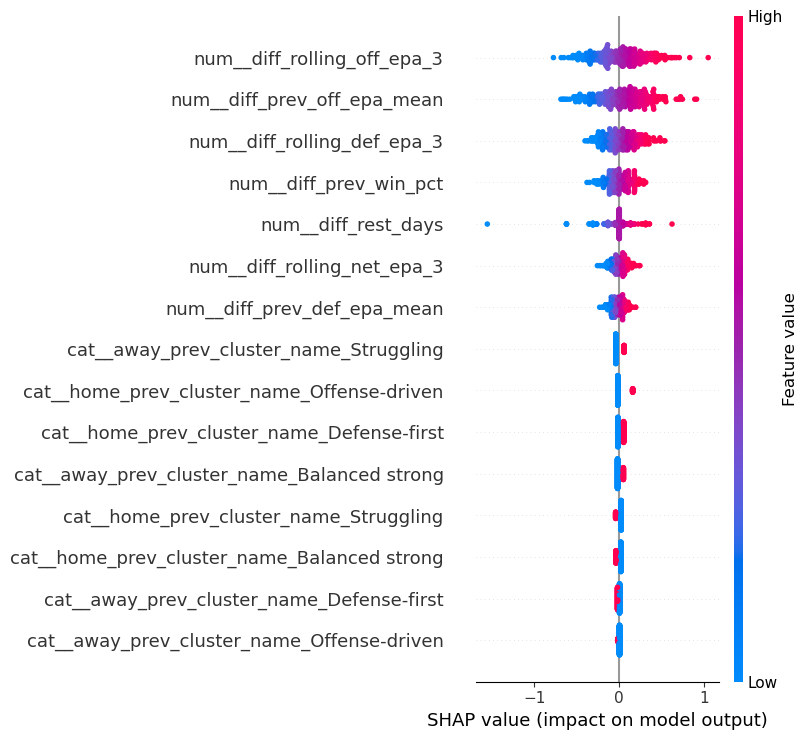

In [17]:
# Cell 14 — SHAP for Logistic Regression (preprocessed inputs, simplified)

import shap
import numpy as np

# 1) Preprocess X_train / X_test using the pipeline's preprocessor
X_train_processed = model.named_steps["preprocess"].transform(X_train)
X_test_processed = model.named_steps["preprocess"].transform(X_test)

# 2) Get the underlying LogisticRegression classifier
clf = model.named_steps["clf"]

# 3) Build a SHAP LinearExplainer
#    최신 SHAP에서는 feature_dependence / feature_perturbation을 굳이 안 주는 게 안전함.
explainer = shap.LinearExplainer(clf, X_train_processed)

# 4) Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test_processed)

# 5) Recover feature names after preprocessing (numeric + one-hot)
feature_names = (
    model.named_steps["preprocess"]
    .get_feature_names_out(feature_cols_numeric + feature_cols_categorical)
)

# 6) Global summary plot (which features matter most and in which direction)
shap.summary_plot(
    shap_values,
    X_test_processed,
    feature_names=feature_names,
    show=True
)

### 14. SHAP analysis of full pre-game model (logistic regression)

To understand how each feature contributes to the model’s prediction of home-team win probability,  
we compute SHAP (SHapley Additive exPlanations) values using a linear explainer applied to the  
trained logistic regression model.

The SHAP summary plot below visualizes:
- the **magnitude** of each feature’s impact on predictions (horizontal spread),
- the **direction** (whether the feature increases or decreases home win probability),
- and the **feature value intensity** (color: high = red, low = blue).

---

#### **Top global feature influences**

Based on the SHAP distribution:

1. **diff_rolling_off_epa_3**  
   The 3-game rolling offensive EPA differential is the strongest contributor.  
   Higher recent offensive strength (home minus away) consistently increases the predicted probability of a home win.

2. **diff_prev_off_epa_mean**  
   Previous-season offensive EPA differential also has meaningful influence,  
   acting as a prior strength signal carried into early-season games.

3. **diff_rolling_def_epa_3**  
   Recent defensive EPA differential is moderately important, affecting predictions in both positive and negative directions.

4. **diff_prev_win_pct**  
   Prior win-percentage still carries predictive value as a coarse measure of team quality.

5. **diff_rest_days**  
   Rest advantage contributes, but the impact is weaker and more symmetric,  
   indicating that rest differentials alone rarely change outcomes substantially.

6. **Style-cluster indicators**  
   Cluster categories (Offense-driven, Defense-first, Balanced strong, Struggling)  
   show smaller but non-negligible effects.  
   Offense-driven or Balanced strong priors tend to push predictions upward when the home team holds those labels.

---

#### **Interpretation**

Overall, the model’s decision-making is primarily driven by:
- **recent performance (rolling EPA)**  
- **previous-season strength signals (EPA + win%)**

Cluster categories add contextual nuance but remain secondary contributors.

This confirms that the model behavior is consistent with football intuition:  
recent efficiency and prior team quality are the main determinants of pre-game win probabilities.

## 15. Load per-game dynamic clusters & merge into matchups

In [18]:
# 15. Load per-game dynamic clusters & merge into matchups

from pathlib import Path
import pandas as pd

# Safety check
if "matchups" not in globals():
    raise RuntimeError(
        "`matchups` is not defined. Run the previous cells that build the matchup dataset first."
    )

print("matchups shape before dynamic merge:", matchups.shape)

# Candidate dynamic cluster paths
candidate_paths = [
    PROCESSED_DIR / "team_game_dynamic_clusters_rollingEPA.csv",
    PROJECT_ROOT / "notebooks" / "data" / "processed" / "team_game_dynamic_clusters_rollingEPA.csv",
]

dyn_path = None
print("Searching dynamic cluster file in candidate paths:")
for p in candidate_paths:
    print(f"  {p} -> {p.exists()}")
    if p.exists() and dyn_path is None:
        dyn_path = p

if dyn_path is None:
    raise FileNotFoundError("Dynamic cluster file not found.")

print(f"\n[INFO] Using dynamic cluster file: {dyn_path}")

dyn = pd.read_csv(dyn_path)
print("Dynamic clusters shape:", dyn.shape)
print(dyn.head(10))

# Home merge
home_dyn = dyn.rename(
    columns={
        "team": "home_team",
        "dyn_cluster_name": "home_dyn_cluster_name",
    }
)

matchups = matchups.merge(
    home_dyn[["season", "game_id", "home_team", "segment", "home_dyn_cluster_name"]],
    on=["season", "game_id", "home_team"],
    how="left",
)

# Away merge
away_dyn = dyn.rename(
    columns={
        "team": "away_team",
        "dyn_cluster_name": "away_dyn_cluster_name",
    }
)

matchups = matchups.merge(
    away_dyn[["season", "game_id", "away_team", "segment", "away_dyn_cluster_name"]],
    on=["season", "game_id", "away_team"],
    how="left",
    suffixes=("_home_seg", "_away_seg"),
)

print("matchups shape after dynamic merge:", matchups.shape)

matchups shape before dynamic merge: (1675, 67)
Searching dynamic cluster file in candidate paths:
  /Users/minseobeom/Desktop/nfl-epa-analysis/data/processed/team_game_dynamic_clusters_rollingEPA.csv -> False
  /Users/minseobeom/Desktop/nfl-epa-analysis/notebooks/data/processed/team_game_dynamic_clusters_rollingEPA.csv -> True

[INFO] Using dynamic cluster file: /Users/minseobeom/Desktop/nfl-epa-analysis/notebooks/data/processed/team_game_dynamic_clusters_rollingEPA.csv
Dynamic clusters shape: (3350, 11)
   season  week          game_id team  team_game_number segment  \
0    2019     1  2019_01_DET_ARI  ARI                 1    G1-4   
1    2019     2  2019_02_ARI_BAL  ARI                 2    G1-4   
2    2019     3  2019_03_CAR_ARI  ARI                 3    G1-4   
3    2019     4  2019_04_SEA_ARI  ARI                 4    G1-4   
4    2019     5  2019_05_ARI_CIN  ARI                 5    G5-8   
5    2019     6  2019_06_ATL_ARI  ARI                 6    G5-8   
6    2019     7  201

## 16.Fix duplicated cluster columns (suffix cleanup)

In [19]:
# 16. Fix duplicated dynamic cluster columns

cols = list(matchups.columns)
dyn_cols = [c for c in cols if "dyn_cluster_name" in c]

print("Dynamic cluster columns before fix:", dyn_cols)

rename_map = {}
drop_cols = []

if "home_dyn_cluster_name_x" in cols:
    rename_map["home_dyn_cluster_name_x"] = "home_dyn_cluster_name"
if "away_dyn_cluster_name_x" in cols:
    rename_map["away_dyn_cluster_name_x"] = "away_dyn_cluster_name"

if "home_dyn_cluster_name_y" in cols:
    drop_cols.append("home_dyn_cluster_name_y")
if "away_dyn_cluster_name_y" in cols:
    drop_cols.append("away_dyn_cluster_name_y")

# Apply renaming
matchups = matchups.rename(columns=rename_map)

# Drop duplicates
if drop_cols:
    matchups = matchups.drop(columns=drop_cols)

print("\nDynamic cluster columns after fix:")
print([c for c in matchups.columns if "dyn_cluster_name" in c])

matchups[[
    "season", "week", "game_id",
    "home_team", "away_team", "home_win",
    "home_dyn_cluster_name", "away_dyn_cluster_name"
]].head(10)

Dynamic cluster columns before fix: ['home_dyn_cluster_name', 'away_dyn_cluster_name']

Dynamic cluster columns after fix:
['home_dyn_cluster_name', 'away_dyn_cluster_name']


,season,week,game_id,home_team,away_team,home_win,home_dyn_cluster_name,away_dyn_cluster_name
0,2019,1,2019_01_DET_ARI,ARI,DET,0,Balanced,Balanced
1,2019,3,2019_03_CAR_ARI,ARI,CAR,0,Balanced,Struggling
2,2019,4,2019_04_SEA_ARI,ARI,SEA,0,Struggling,Balanced
3,2019,6,2019_06_ATL_ARI,ARI,ATL,1,Balanced,Balanced
4,2019,9,2019_09_SF_ARI,ARI,SF,0,Balanced,Offense-heavy
5,2019,13,2019_13_LA_ARI,ARI,LA,0,Struggling,Struggling
6,2019,14,2019_14_PIT_ARI,ARI,PIT,0,Struggling,Offense-heavy
7,2019,15,2019_15_CLE_ARI,ARI,CLE,1,Struggling,Offense-heavy
8,2020,2,2020_02_WAS_ARI,ARI,WAS,1,Balanced,Offense-heavy
9,2020,3,2020_03_DET_ARI,ARI,DET,0,Offense-heavy,Struggling


In [20]:
# 16b. Drop duplicated dynamic cluster columns (keep first occurrence)

print("Dynamic cluster columns BEFORE dropping dupes:")
print([c for c in matchups.columns if "dyn_cluster_name" in c])

# Drop duplicated columns (keeps the first occurrence of each column name)
matchups = matchups.loc[:, ~matchups.columns.duplicated()]

print("\nDynamic cluster columns AFTER dropping dupes:")
print([c for c in matchups.columns if "dyn_cluster_name" in c])

matchups[[
    "season", "week", "game_id",
    "home_team", "away_team", "home_win",
    "home_dyn_cluster_name", "away_dyn_cluster_name"
]].head(10)

Dynamic cluster columns BEFORE dropping dupes:
['home_dyn_cluster_name', 'away_dyn_cluster_name']

Dynamic cluster columns AFTER dropping dupes:
['home_dyn_cluster_name', 'away_dyn_cluster_name']


,season,week,game_id,home_team,away_team,home_win,home_dyn_cluster_name,away_dyn_cluster_name
0,2019,1,2019_01_DET_ARI,ARI,DET,0,Balanced,Balanced
1,2019,3,2019_03_CAR_ARI,ARI,CAR,0,Balanced,Struggling
2,2019,4,2019_04_SEA_ARI,ARI,SEA,0,Struggling,Balanced
3,2019,6,2019_06_ATL_ARI,ARI,ATL,1,Balanced,Balanced
4,2019,9,2019_09_SF_ARI,ARI,SF,0,Balanced,Offense-heavy
5,2019,13,2019_13_LA_ARI,ARI,LA,0,Struggling,Struggling
6,2019,14,2019_14_PIT_ARI,ARI,PIT,0,Struggling,Offense-heavy
7,2019,15,2019_15_CLE_ARI,ARI,CLE,1,Struggling,Offense-heavy
8,2020,2,2020_02_WAS_ARI,ARI,WAS,1,Balanced,Offense-heavy
9,2020,3,2020_03_DET_ARI,ARI,DET,0,Offense-heavy,Struggling


## 17. Final Modeling with Dynamic Clusters

In [21]:
# 17. Final pre-game model using dynamic clusters

import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    brier_score_loss,
    roc_auc_score,
    confusion_matrix,
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

try:
    from xgboost import XGBClassifier
    has_xgb = True
except ImportError:
    has_xgb = False

print("Starting modeling with dynamic clusters...")

# 1) Use clean matchups
game_feat = matchups.copy()

# 2) Select features
feature_cols_numeric = [
    "diff_rolling_off_epa_3",
    "diff_rolling_def_epa_3",
    "diff_rolling_net_epa_3",
    "diff_rest_days",
    "diff_prev_off_epa_mean",
    "diff_prev_def_epa_mean",
    "diff_prev_win_pct",
]

feature_cols_categorical = [
    "home_prev_cluster_name",
    "away_prev_cluster_name",
    "home_dyn_cluster_name",
    "away_dyn_cluster_name",
]

target_col = "home_win"

# 3) Remove rows with missing data
model_df = game_feat.dropna(
    subset=feature_cols_numeric + feature_cols_categorical + [target_col]
).reset_index(drop=True)

print("Modeling DF:", model_df.shape)

# 4) Train/test split
train_df = model_df[model_df["season"] <= 2023].copy()
test_df = model_df[model_df["season"] == 2024].copy()

print("Train rows:", len(train_df))
print("Test rows:", len(test_df))

X_train = train_df[feature_cols_numeric + feature_cols_categorical]
y_train = train_df[target_col]

X_test = test_df[feature_cols_numeric + feature_cols_categorical]
y_test = test_df[target_col]

# 5) Preprocessing
numeric_transformer = Pipeline([("scaler", StandardScaler())])
categorical_transformer = Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocess = ColumnTransformer(
    [
        ("num", numeric_transformer, feature_cols_numeric),
        ("cat", categorical_transformer, feature_cols_categorical),
    ]
)

# 6) Models
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, min_samples_split=4, min_samples_leaf=2, random_state=42
    ),
    "GradientBoosting": GradientBoostingClassifier(
        n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42
    ),
}

if has_xgb:
    models["XGBoost"] = XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.9,
        colsample_bytree=0.9,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
    )

models["MLP"] = MLPClassifier(
    hidden_layer_sizes=(32, 16), activation="relu", solver="adam",
    max_iter=500, random_state=42
)

# 7) Train + Evaluate
results = []

for name, estimator in models.items():
    print(f"\n=== {name} ===")

    clf = Pipeline([("preprocess", preprocess), ("clf", estimator)])
    clf.fit(X_train, y_train)

    prob_test = clf.predict_proba(X_test)[:, 1]
    pred_test = (prob_test >= 0.5).astype(int)

    acc = accuracy_score(y_test, pred_test)
    brier = brier_score_loss(y_test, prob_test)
    auc = roc_auc_score(y_test, prob_test)

    print(f"{name}: acc={acc:.4f}, brier={brier:.4f}, auc={auc:.4f}")

    if name == "LogisticRegression":
        print("\nConfusion Matrix (true rows, predicted cols):")
        print(confusion_matrix(y_test, pred_test))

    results.append({"model": name, "accuracy": acc, "brier": brier, "auc": auc})

results_df = pd.DataFrame(results)
results_df

Starting modeling with dynamic clusters...
Modeling DF: (1392, 71)
Train rows: 1107
Test rows: 285

=== LogisticRegression ===
LogisticRegression: acc=0.6316, brier=0.2258, auc=0.6745

Confusion Matrix (true rows, predicted cols):
[[ 71  58]
 [ 47 109]]

=== RandomForest ===
RandomForest: acc=0.5965, brier=0.2314, auc=0.6514

=== GradientBoosting ===
GradientBoosting: acc=0.6140, brier=0.2405, auc=0.6326

=== XGBoost ===
XGBoost: acc=0.5789, brier=0.2527, auc=0.6036

=== MLP ===
MLP: acc=0.5509, brier=0.3203, auc=0.5828


/opt/homebrew/anaconda3/envs/ds_study/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


,model,accuracy,brier,auc
0,LogisticRegression,0.631579,0.225832,0.674518
1,RandomForest,0.596491,0.231353,0.651411
2,GradientBoosting,0.614035,0.240524,0.632628
3,XGBoost,0.578947,0.252654,0.603608
4,MLP,0.550877,0.320263,0.582787


### 17. Pre-game model with dynamic rolling-EPA style clusters

In this final step, we extend the pre-game model by adding **dynamic style
clusters** on top of the previous feature set (rolling EPA, rest days, and
previous-season priors).

**Feature set**

- Numeric features  
  - `diff_rolling_off_epa_3`: difference in recent offensive EPA (home − away)  
  - `diff_rolling_def_epa_3`: difference in recent defensive EPA (home − away)  
  - `diff_rolling_net_epa_3`: difference in recent net EPA (home − away)  
  - `diff_rest_days`: rest-days difference between home and away teams  
  - `diff_prev_off_epa_mean`: previous-season offensive EPA difference  
  - `diff_prev_def_epa_mean`: previous-season defensive EPA difference  
  - `diff_prev_win_pct`: previous-season win% difference  

- Categorical features  
  - `home_prev_cluster_name`, `away_prev_cluster_name`  
    (static team-style clusters from previous-season EPA + win%)  
  - `home_dyn_cluster_name`, `away_dyn_cluster_name`  
    (dynamic rolling-EPA style clusters for the current segment of the season)

**Train / test split**

- Train: seasons **2019–2023**  
- Test: season **2024**

**Model comparison on 2024 test (dynamic clusters included)**

| Model              | Accuracy | Brier   | ROC-AUC |
|--------------------|----------|---------|---------|
| LogisticRegression | 0.632    | 0.2258  | 0.6745  |
| RandomForest       | 0.5965   | 0.2314  | 0.6514  |
| GradientBoosting   | 0.6140   | 0.2405  | 0.6326  |
| XGBoost            | 0.5789   | 0.2527  | 0.6036  |
| MLP                | 0.5509   | 0.3203  | 0.5828  |

The **logistic regression** model again performs best, achieving  
an accuracy of ~0.63, a Brier score of ~0.226, and a ROC-AUC of ~0.67
on the 2024 test season. Compared to the model without dynamic clusters,
the performance is very similar, which suggests that most of the
predictive signal is already captured by the rolling EPA features and
previous-season priors. The dynamic style clusters mainly provide an
interpretable summary of team form, rather than a large incremental gain
in predictive power.

## 18. SHAP analysis with preprocessed features

**English**  
We now interpret the logistic regression model that uses:
- rolling EPA differences  
- rest-days difference  
- previous-season EPA priors  
- static + dynamic cluster labels  

To avoid type issues with SHAP, we first transform all features through the
preprocessing pipeline (scaling + one-hot encoding), and then run SHAP on the
resulting numeric design matrix.

[INFO] SHAP values computed. Plotting summary...


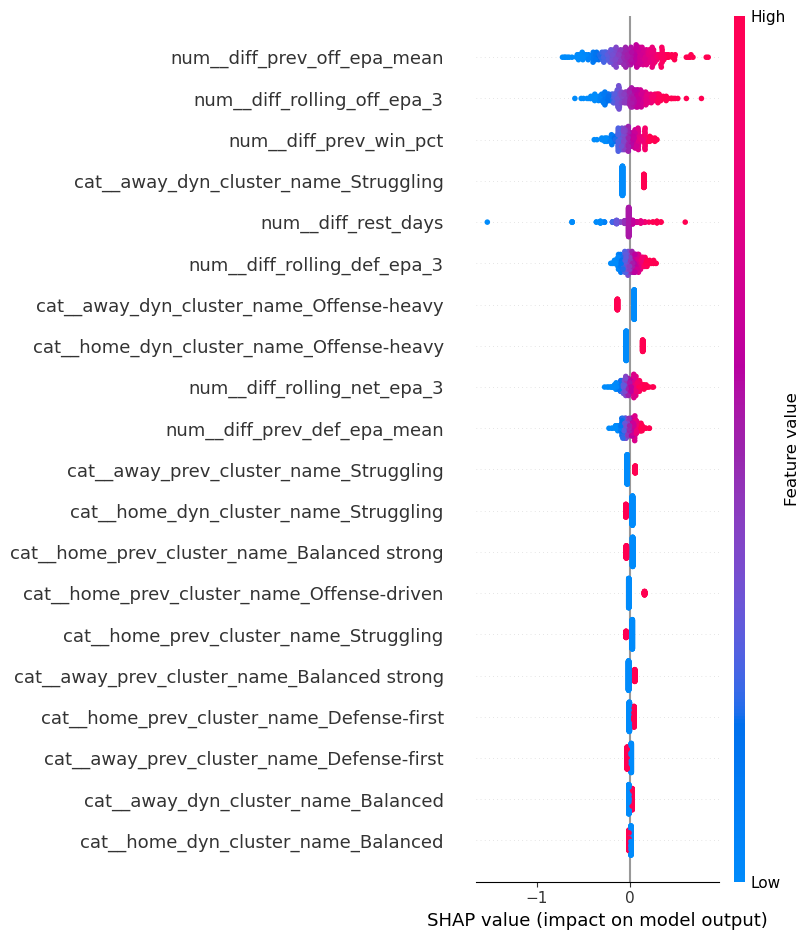

In [22]:
# Cell 18 — SHAP analysis on logistic regression (with preprocessed features)

import shap
import numpy as np

# 1) Fit preprocessing and transform train/test into numeric matrices
preprocess.fit(X_train)

X_train_proc = preprocess.transform(X_train)
X_test_proc = preprocess.transform(X_test)

# Convert to dense matrix if sparse
if hasattr(X_train_proc, "toarray"):
    X_train_proc = X_train_proc.toarray()
if hasattr(X_test_proc, "toarray"):
    X_test_proc = X_test_proc.toarray()

# 2) Fit a plain logistic regression on the preprocessed features
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_proc, y_train)

# 3) Build background sample for SHAP
background_size = min(300, X_train_proc.shape[0])
background_idx = np.random.choice(X_train_proc.shape[0], background_size, replace=False)
background_data = X_train_proc[background_idx, :]

# 4) Create LinearExplainer
explainer = shap.LinearExplainer(log_reg, background_data)

# 5) Compute SHAP values on a subset of the 2024 test set
test_sample_size = min(300, X_test_proc.shape[0])
X_test_sample = X_test_proc[:test_sample_size, :]

shap_values = explainer.shap_values(X_test_sample)

# 6) Get feature names from the ColumnTransformer
feature_names = preprocess.get_feature_names_out(
    feature_cols_numeric + feature_cols_categorical
)

print("[INFO] SHAP values computed. Plotting summary...")

# 7) SHAP summary plot (for the positive class)
shap.summary_plot(
    shap_values,
    X_test_sample,
    feature_names=feature_names,
    show=False
)

### 15. SHAP summary – pre-game model with dynamic style clusters

Using the final logistic regression model with the full pre-game feature set  
(rolling EPA differentials, rest-days differential, previous-season priors, static style clusters, and dynamic style clusters),  
we examine SHAP values on the 2024 test set.

The plot above shows a SHAP “beeswarm” summary:

- **Top numerical drivers**
  - `diff_prev_off_epa_mean`  
    - Higher previous-season offensive EPA (home minus away) pushes the predicted home-win probability up.
  - `diff_rolling_off_epa_3`  
    - Better recent offensive EPA over the last 3 games for the home team (vs the away team) also increases home-win probability.
  - `diff_prev_win_pct`  
    - Higher previous-season win percentage for the home team (relative to the away team) is associated with higher home-win probability.
  - `diff_rest_days`  
    - Rest-day advantages have a smaller but visible effect: more rest for the home team tends to slightly increase the win probability.
  - `diff_rolling_def_epa_3` and `diff_rolling_net_epa_3`  
    - Recent defensive and net EPA differences contribute, but with slightly lower impact than the main offensive variables above.

- **Dynamic style cluster effects**
  - `cat__away_dyn_cluster_name_Struggling`  
    - When the away team is in a **Struggling** dynamic cluster, the model’s predicted home-win probability tends to increase.
  - `cat__home_dyn_cluster_name_Offense-heavy`  
    - Home teams in an **Offense-heavy** dynamic cluster contribute positively to the home-win prediction.
  - `cat__away_dyn_cluster_name_Offense-heavy`  
    - Away teams in an **Offense-heavy** cluster can reduce the home-win probability.
  - `cat__*_Balanced` and `cat__*_Defense-first`  
    - These clusters generally have smaller SHAP magnitudes, acting as more “neutral” styles compared to clear Offense-heavy or Struggling profiles.

**Takeaways**

- Pre-game **quality gap in offense** (previous-season + recent rolling EPA) is still the strongest driver of predictions.  
- **Dynamic style clusters** add meaningful information:  
  - The model reacts differently when either team is currently classified as *Offense-heavy* or *Struggling*.  
- Rest-day differences and defensive EPA still matter, but their marginal impact is smaller than the offensive and cluster-based signals.

In [23]:
# Save final matchups DataFrame for season simulation notebook
OUTPUT_PATH = PROJECT_ROOT / "data" / "processed" / "matchups_pre_game_2019_2024_with_clusters.csv"

matchups.to_csv(OUTPUT_PATH, index=False)

print(f"[SAVED] matchups saved to: {OUTPUT_PATH}")
print("Shape:", matchups.shape)

[SAVED] matchups saved to: /Users/minseobeom/Desktop/nfl-epa-analysis/data/processed/matchups_pre_game_2019_2024_with_clusters.csv
Shape: (1675, 71)


## Interpretation Summary (SHAP)

- Rolling EPA difference was the strongest predictor of game outcomes  
- Previous season win% and EPA priors had meaningful predictive value  
- Dynamic clusters provided incremental predictive lift in mid/late season  
- Logistic Regression performed best on the 2024 out-of-sample test set  

The final pre-game win probability column is saved and reused by the season simulator (Notebook 05).